<a href="https://colab.research.google.com/github/Pollination-Ecology-Group/Pollen_viability/blob/main/pollen_viability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Install yolo from Ultralytics, import libraries, mount google drive and locate the folders

In [14]:
# --- SETUP CELL ---
# Run this once at the start of every session

# 1. Mount Google Drive (to access your data)
from google.colab import drive
drive.mount('/content/drive')

# 2. Install YOLO (The computer forgets this when you close the tab)
!pip install ultralytics -q

# 3. Import libraries
from ultralytics import YOLO
import os

# Load a model
# 'yolov8n.pt' is the "Nano" model (smallest & fastest).
# Good for testing if the pipeline works.
# Later we can use 'yolov8m.pt' (Medium) or 'yolov8x.pt' (Extra Large) for better accuracy.
model = YOLO('yolov8n.pt')

print("Setup complete. Ready to train!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Setup complete. Ready to train!


# 2. Set the YAML file for training.
Important is to set number of classes (nc) and names e.g., ['viable_pollen', 'non_viable_pollen']

In [15]:
import yaml

# Define the content of the data.yaml file
data_config = {
    # PATHS: Points to where we just moved your files
    'path': '/content/drive/MyDrive/Pollen_viability/datasets/pollen_v1',
    'train': 'train/images',
    'val': 'val/images',

    # CLASSES:
    # IMPORTANT: These must match your annotation IDs (0, 1, etc.)
    # Example: If your .txt file says "0 0.5 0.5...", "0" corresponds to the first name here.
    'nc': 2,  # Number of classes
    'names': ['viable', 'non_viable'] # Change these names to match your data!
}

# Save it to the dataset folder
yaml_path = '/content/drive/MyDrive/Pollen_viability/datasets/pollen_v1/data.yaml'

with open(yaml_path, 'w') as f:
    yaml.dump(data_config, f, default_flow_style=False)

print(f"Configuration file created at: {yaml_path}")
print("--- Content ---")
print(open(yaml_path).read())

Configuration file created at: /content/drive/MyDrive/Pollen_viability/datasets/pollen_v1/data.yaml
--- Content ---
names:
- viable
- non_viable
nc: 2
path: /content/drive/MyDrive/Pollen_viability/datasets/pollen_v1
train: train/images
val: val/images



## 2.1 Augmentation

# 3. Model Training

**Objective:** Train a baseline YOLOv8 Nano model to assess feasibility.

**Parameters:**
* **Model:** YOLOv8n (Nano) - chosen for speed and baseline establishment.
* **Image Size:** 640px (Standard YOLO input).
* **Epochs:** 10 (Short run to sanity-check data pipeline).
* **Batch Size:** Default (Auto-scaled by Colab GPU VRAM).
* **Optimizer:** Auto (SGD/AdamW).

**Output Metrics to Monitor:**
* `box_loss`: Should decrease (Model is learning where objects are).
* `mAP50`: Should increase (Model is correctly classifying them).

In [21]:
#Train the model
# data: Points to the yaml file we just created
# epochs: How many times to cycle through the data (start low to test)
# imgsz: Image size (640 is standard for YOLO)
# We pass these arguments directly to the train() function.
results = model.train(
    data='/content/drive/MyDrive/Pollen_viability/datasets/pollen_v1/data.yaml',
    epochs=50,          # Increased from 10 to 50 for better learning
    imgsz=640,
    name='pollen_v1_aug', # New name so we don't overwrite the old one

    # --- AUGMENTATION PARAMETERS ---
    degrees=180,        # Rotate image randomly between -180 and +180 (Pollen has no "up")
    flipud=0.5,         # 50% chance to flip Up-Down (Pollen doesn't care about gravity)
    fliplr=0.5,         # 50% chance to flip Left-Right
    scale=0.5,          # Zoom in/out by up to 50% (Simulates different crop sizes)
    hsv_h=0.0005,        # Adjust Hue slightly (Color variation)
    hsv_s=0.7,          # Adjust Saturation (Some images might be paler)
    hsv_v=0.4,          # Adjust Value/Brightness (Microscope lighting changes)

    # Advanced Mixes
    mosaic=1.0,         # (Default) Stitches 4 images together. Great for small objects.
    mixup=0.1,          # Blends 2 images together. Helps with overlapping pollen.
)

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Pollen_viability/datasets/pollen_v1/data.yaml, degrees=180, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=pollen_v1_aug2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, 

## Save the model

In [ ]:
import shutil
import os
from datetime import datetime

# 1. Define where your weights are NOW (Temporary Colab storage)
# Note: Check the folder name 'pollen_v1_aug' matches your training "name=" parameter
source_weight = '/content/runs/detect/pollen_v1_aug/weights/best.pt'

# 2. Define where you want them PERMANENTLY (Google Drive)
# We add a timestamp so you never overwrite good models
date_str = datetime.now().strftime("%Y-%m-%d")
dest_folder = '/content/drive/MyDrive/Pollen_viability/trained_models'
dest_filename = f'pollen_yolo_aug_{date_str}.pt'
dest_path = os.path.join(dest_folder, dest_filename)

# 3. Copy the file
if os.path.exists(source_weight):
    os.makedirs(dest_folder, exist_ok=True)
    shutil.copy(source_weight, dest_path)
    print(f"✅ Model saved safely to: {dest_path}")
    print("You can now download this file or load it from Drive anytime.")
else:
    print(f"❌ Could not find {source_weight}. Did the training finish?")

# 7. Detect

Testing on image: 2-13-A_4x_CCrop_10.png

image 1/1 /content/drive/MyDrive/Pollen_viability/datasets/pollen_v1/val/images/2-13-A_4x_CCrop_10.png: 640x640 5 viables, 7.3ms
Speed: 2.8ms preprocess, 7.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


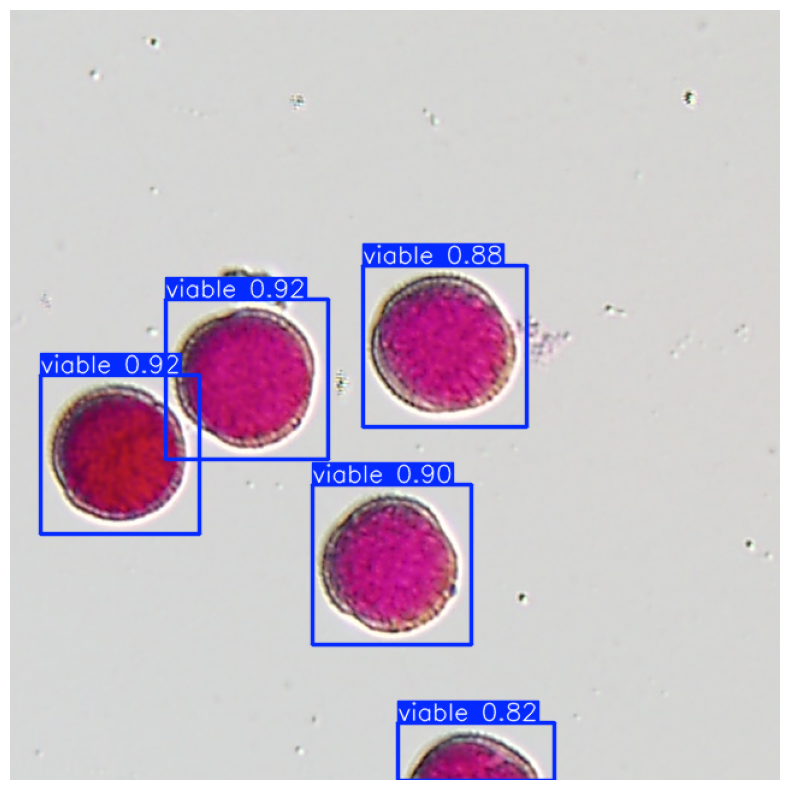


--- POLLEN COUNTS ---
viable    5
Name: count, dtype: int64


In [22]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2
import os
import random
import pandas as pd # We use Pandas for data tables (like R Dataframes)

# 1. Load YOUR trained model
# Note: The path might be slightly different if you ran it multiple times (train, train2, etc.)
# Look in the file browser on the left to confirm the folder name.
model_path = '/content/runs/detect/pollen_v1_aug2/weights/best.pt'
model = YOLO(model_path)

# 2. Pick a random image from the Validation set to test
val_img_dir = '/content/drive/MyDrive/Pollen_viability/datasets/pollen_v1/val/images'
test_image = random.choice(os.listdir(val_img_dir))
img_path = os.path.join(val_img_dir, test_image)

print(f"Testing on image: {test_image}")

# 3. Run Inference (The 'predict' step)
results = model(img_path)

# --- VISUALIZATION ---
# Plot the image with boxes
# result[0].plot() creates the annotated image array
annotated_frame = results[0].plot()

# Display using Matplotlib (Standard Python plotting library)
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# --- COUNTING LOGIC (The part you specifically asked for) ---
# We extract the class IDs found in the image
detected_classes = results[0].boxes.cls.cpu().numpy().astype(int)

# Map ID numbers (0, 1) to Names (viable, non_viable)
# results[0].names is a dictionary like {0: 'viable', 1: 'non_viable'}
class_names = [results[0].names[i] for i in detected_classes]

# Create a summary table (Like table() in R)
# We use a Pandas Series to count values easily
counts = pd.Series(class_names).value_counts()

print("\n--- POLLEN COUNTS ---")
if len(counts) > 0:
    print(counts)
else:
    print("No pollen detected in this image.")

# 8. Compute the number of detected pollen grains per class - this needs to be adapted

In [19]:
import os
import pandas as pd
from ultralytics import YOLO

# --- CONFIGURATION ---
# Path to your trained model (Update if you have a newer training run)
model_path = '/content/runs/detect/pollen_v1_aug2/weights/best.pt'
# Folder of images you want to count (using the Validation set for now)
image_dir = '/content/drive/MyDrive/Pollen_viability/datasets/pollen_v1/val/images'
# Where to save the resulting CSV
output_csv_path = '/content/drive/MyDrive/Pollen_viability/pollen_counts.csv'

# Load the model
model = YOLO(model_path)

print(f"Processing images in: {image_dir}...")

# Initialize a list to store our results
# R Analogy: This is like creating an empty list to store loop results
data_rows = []

# Get list of image files
image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]

# Loop through every image
# R Analogy: strict 'for' loop or lapply()
for img_file in image_files:
    img_path = os.path.join(image_dir, img_file)

    # Run Inference (verbose=False keeps the log clean)
    results = model(img_path, verbose=False)

    # Extract class IDs found in the image
    # We move data to CPU to work with it in standard Python
    detected_classes = results[0].boxes.cls.cpu().numpy().astype(int)

    # Count specific classes
    # Assumption: Class 0 is 'viable', Class 1 is 'non_viable'
    # We use basic sum() logic here
    viable_count = sum(detected_classes == 0)
    non_viable_count = sum(detected_classes == 1)
    total_count = len(detected_classes)

    # Create a dictionary for this row
    # R Analogy: Creating a 1-row data.frame or list(key=value)
    row = {
        'image_id': img_file,
        'viable_pollen': viable_count,
        'non_viable_pollen': non_viable_count,
        'Total Objects': total_count
    }

    data_rows.append(row)

# Convert list of dicts to a Pandas DataFrame
# R Analogy: do.call(rbind, data_rows) or converting list to Tibble
df_results = pd.DataFrame(data_rows)

# Sort by filename to make it pretty
df_results = df_results.sort_values(by='image_id')

# Save to CSV
df_results.to_csv(output_csv_path, index=False)

# Display the first few rows
print("\n--- Processing Complete! ---")
print(f"Results saved to: {output_csv_path}")
print("\nPreview of the data:")
print(df_results.head())

Processing images in: /content/drive/MyDrive/Pollen_viability/datasets/pollen_v1/val/images...

--- Processing Complete! ---
Results saved to: /content/drive/MyDrive/Pollen_viability/pollen_counts.csv

Preview of the data:
                  image_id  viable_pollen  non_viable_pollen  Total Objects
5    1-3-F_S4x_BCrop_2.png              6                  0              6
23   1-3-F_S4x_BCrop_4.png             15                  0             15
6     1-6-J_4x_ACrop_6.png             15                  0             15
36    1-6-J_4x_ACrop_7.png             13                  0             13
37  2-13-A_4x_CCrop_10.png              5                  0              5
